# Making Business Decisions Based on Data for E-Commerce Store

## Intro

I'm an analyst at a big online store. Together with the marketing department, we've compiled a list of hypotheses that may help boost revenue.
My task is to prioritize these hypotheses, launch an A/B test, and analyze the results.

**Description of the Data:**

Data used in the first part of the project:

/datasets/hypotheses_us.csv
- Hypotheses — brief descriptions of the hypotheses
- Reach — user reach, on a scale of one to ten
- Impact — impact on users, on a scale of one to ten
- Confidence — confidence in the hypothesis, on a scale of one to ten
- Effort — the resources required to test a hypothesis, on a scale of one to ten. The higher the Effort value, the more resource-intensive the test.

Data used in the second part of the project:

/datasets/orders_us.csv
- transactionId — order identifier
- visitorId — identifier of the user who placed the order
- date — of the order
- revenue — from the order
- group — the A/B test group that the user belongs to

/datasets/visits_us.csv
- date — date
- group — A/B test group
- visits — the number of visits on the date specified in the A/B test group specified

<h2>Tables Of Contents <a class="anchor" id="table_of_contents"></a></h2>

- [1. Study the general information & Data Preprocessing](#data_pre)
- [2. Prioritizing Hypotheses](#hypotheses)
- [3. A/B Test Analysis](#test)
 - [Graph cumulative revenue by group](#question1)
 - [Graph cumulative average order size by group](#question2)
 - [Graph the relative difference in cumulative average order size](#question3)
 - [Calculate each group's conversion rate](#question4)
 - [Plot a scatter chart of the number of orders per user](#question5)
 - [Calculate the 95th and 99th percentiles for the number of orders per user](#question6)
 - [Plot a scatter chart of order prices](#question7)
 - [Calculate the 95th and 99th percentiles of order prices](#question8)
 - [Find the statistical significance of the difference in conversion between the groups using the raw data](#question9)
 - [Find the statistical significance of the difference in average order size between the groups using the raw data](#question10)
 - [Find the statistical significance of the difference in conversion between the groups using the filtered data](#question11)
 - [Find the statistical significance of the difference in average order size between the groups using the filtered data](#question12)
- [4. Decision based on the test results](#decision) 

## Download the data and prepare it for analysis

<a class="anchor" id="data_pre"></a>
[Go back to the Table of Contents](#table_of_contents)

In [1]:
# !pip install -Uq plotly

Import necessary libraries.

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import plotly.express as px

Load and optimize data files to suitable variables.

In [3]:
try:
    hypotheses = pd.read_csv('hypotheses_us.csv', sep=';')
    orders = pd.read_csv('orders_us.csv', parse_dates = ['date'])
    visits = pd.read_csv('visits_us.csv', parse_dates = ['date'])
except:
    hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
    orders = pd.read_csv('/datasets/orders_us.csv', parse_dates = ['date'])
    visits = pd.read_csv('/datasets/visits_us.csv', parse_dates = ['date'])

Take a general look at the data frames using head() method.

In [4]:
#set column width to 400
pd.set_option('max_colwidth', 400)

hypotheses.head()

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1


In [5]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [6]:
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Notice the columns names in `hypotheses`, they are written with capital letters which is a bad practice, we'll change that so the names fit programming conventions.

In [7]:
#change columns names to lower-case letters
hypotheses.columns = hypotheses.columns.str.lower()

Now, let's look for missing values in each dataframe.

In [8]:
print('Missing values in hypotheses df: \n{}'.format(hypotheses.isnull().sum()))
print()
print('Missing values in orders df: \n{}'.format(orders.isnull().sum()))
print()
print('Missing values in visits df: \n{}'.format(visits.isnull().sum()))

Missing values in hypotheses df: 
hypothesis    0
reach         0
impact        0
confidence    0
effort        0
dtype: int64

Missing values in orders df: 
transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

Missing values in visits df: 
date      0
group     0
visits    0
dtype: int64


No missing values found in any of the data frames.

Using info() method, let's validate that each column of each data frame has the correct data type:

In [9]:
hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


In [11]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Every column has the correct data type, great!

Next, let's check if we got any duplicates in our data:

In [12]:
print('Number of duplicates in the hypotheses df: {}'.format(hypotheses.duplicated().sum()))
print()
print('Number of duplicates in the orders df: {}'.format(orders.duplicated().sum()))
print()
print('Number of duplicates in the visits df: {}'.format(visits.duplicated().sum()))

Number of duplicates in the hypotheses df: 0

Number of duplicates in the orders df: 0

Number of duplicates in the visits df: 0


No duplicates found, awesome!

Last thing before we move on to the next step, let's validate the 'recruiting process' of users to groups A/B.
We want to make sure that each user was assigned to one group only.

In [13]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [14]:
#create a pivot table, for each visitor, find how many groups is he in
n_groups_by_users = (
    orders.drop(['transactionId', 'date', 'revenue'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'group': pd.Series.nunique})
)

#print the number of users that are in both groups
n_bad_users = n_groups_by_users[n_groups_by_users['group'] == 2]['visitorId'].count()

print('The number of users in both groups is: {}'.format(n_bad_users))

The number of users in both groups is: 58


We got 58 users assigned to both groups A and B, probably something went wrong in the recruiting process of these users.
We'll delete the data about these specific users in order to not affect our analysis later on.

In [15]:
#create a list of 'bad users' visitor ID
list_bad_users = n_groups_by_users[n_groups_by_users['group'] == 2]['visitorId']

#create a new orders df without users in the list of 'bad users'
orders = orders.query('visitorId not in @list_bad_users').reset_index(drop=True)

Now, the data in `orders` is clean, and we are ready to move forward to the next step!

### Conclusion

To conclude, at first we loaded the files to data frame variables, and studied the general information of the data.

We noticed an issue with the `hypotheses` columns names, they were written with Capital letters which is a bad practice, we replaced those names with lower-case letters to comply with python programming conventions.

We didn't find any missing values/duplicates in any of the data frames. Moreover, each column in each data frame had the correct data type.

Another issue we encountered is users assigned to both test groups, we found 58 users who were both in the A and B groups, perhaps something went wrong during the recruiting process of these users.
We deleted the data collected for these users to not distort our analysis and the test result.

Finally, after we took those steps we were ready for the analysis stage.

## Prioritizing Hypotheses

<a class="anchor" id="hypotheses"></a>
[Go back to the Table of Contents](#table_of_contents)

In this step, we'll use ICE and RICE frameworks to prioritize hypotheses in `hypotheses`.

Impact, confidence, effort/ease (ICE) is one of the most popular ways of prioritizing problems, here is the formula to calculate ICE Score: `(impact * confidence) / effort`.

There's also a modified version, RICE: `(reach * impact * confidence) / effort`.

Here are the components used in these frameworks and their meaning:
- Reach — how many users will be affected by the update you want to introduce.
- Impact — how strongly this update will affect the users, their experience, and their satisfaction with the product.
- Confidence — how sure you are that your product will affect them in this way.
- Effort — how much will it cost to test the hypothesis.


### Prioritize Hypotheses with ICE/RICE frameworks:

First, let's add a column to `hypotheses`, indicating the number of each hypothesis ('hypotesis_id') based on the indices of the data frame.
Later on it will help us visualize our results more clearly.

In [16]:
#add hypothesis id column based on the index number of the hypothesis.
hypotheses['hypothesis_id'] = hypotheses.index

**ICE:**

Create a new column named 'ice_score' in `hypotheses` with the ICE score of hypotheses.

In [17]:
#calculate the ICE score using the formula (impact * confidence) / effort.
hypotheses['ice_score'] = (hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']

#print first 5 rows of hypotheses df sorted in descending order by 'ice_score'
hypotheses.sort_values(by='ice_score', ascending=False).head()

,hypothesis,reach,impact,confidence,effort,hypothesis_id,ice_score
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,8,16.200000
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,0,13.333333
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,7,11.200000
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,6,8.000000
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,2,7.000000


**RICE:**

Create a new column named 'rice_score' in `hypotheses` with the RICE score of hypotheses.

In [18]:
#calculate the RICE score using the formula (impact * confidence) / effort.
hypotheses['rice_score'] = (hypotheses['reach'] * hypotheses['impact'] * hypotheses['confidence']) / hypotheses['effort']

#print  first 5 rows hypotheses df sorted in descending order by 'rice_score'
hypotheses.sort_values(by='rice_score', ascending=False).head()

,hypothesis,reach,impact,confidence,effort,hypothesis_id,ice_score,rice_score
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,7,11.200000,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,2,7.000000,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,0,13.333333,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,6,8.000000,40.0
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,8,16.200000,16.2


Let's visualize the ICE/RICE scores for each hypothesis:

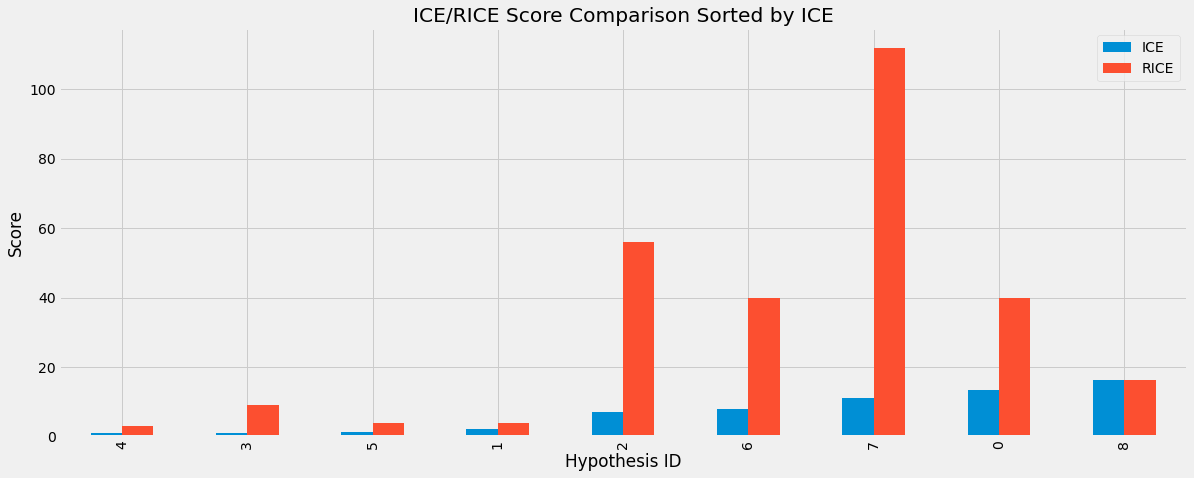

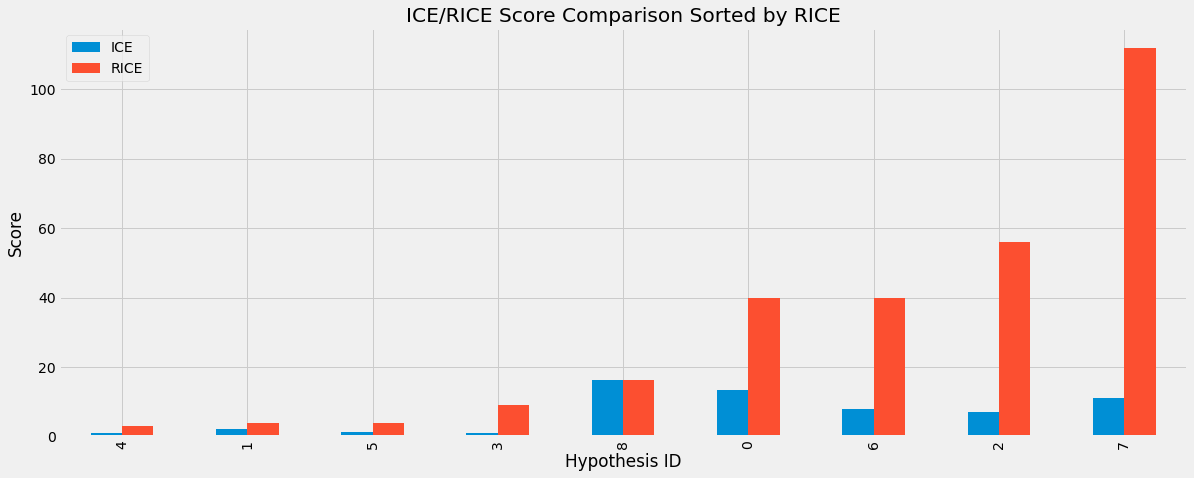

In [19]:
#set theme style
plt.style.use('fivethirtyeight') 

#plot a bar chart to compare between ICE and RICE scores of all hypotheses
hypotheses.sort_values(by='ice_score').plot(kind='bar', x= 'hypothesis_id', y=['ice_score', 'rice_score'],
                                           figsize=(18,7), label=['ICE', 'RICE'])
#set title and x/y labels
plt.gca().set(title='ICE/RICE Score Comparison Sorted by ICE', xlabel='Hypothesis ID', ylabel='Score')

print()

#plot a bar chart to compare between ICE and RICE scores of all hypotheses
hypotheses.sort_values(by='rice_score').plot(kind='bar', x= 'hypothesis_id', y=['ice_score', 'rice_score'],
                                           figsize=(18,7), label=['ICE', 'RICE'])
#set title and x/y labels
plt.gca().set(title='ICE/RICE Score Comparison Sorted by RICE', xlabel='Hypothesis ID', ylabel='Score')


plt.show()

As you can see above, we got different prioritization of hypotheses for each of the frameworks, moreover, the score scale for RICE is a lot bigger than the ICE's scale.

This difference can be contributed to the way these scores are calculated, in the RICE formula we have another component in the numerator which causes the overall score to be bigger than the one in ICE.

Aside from the difference in numbers, we have a more significant difference between the frameworks, which is the variation in prioritization order of hypotheses, let's highlight the main changes between the two frameworks:

1. We'll start with the similarities, for both frameworks, hypotheses 1, 3, 4, and 5 have low scores, meaning these are the least prioritized hypotheses.


2. For ICE, hypothesis 8 got the highest score, for RICE, hypothesis 8 is ranked in 5th place in terms of score.


3. For ICE, hypotheses 0, 7, 6, and 2 are in places 2nd, 3rd, 4th, and 5th, respectively. For RICE, hypotheses 7, 2, 6, and 0 are in places 1st, 2nd, 3rd, and 4th, respectively.


4. Overall, in the RICE framework, the differences between hypothesis scores are significantly bigger than the counterpart in the ICE framework.

It's clear that the 'reach' value used in the RICE score formula had a significant impact on the prioritization order of the hypotheses.

## A/B Test Analysis

<a class="anchor" id="test"></a>
[Go back to the Table of Contents](#table_of_contents)

To plot the graphs we're tasked to plot, and analyze the results of the test, we have to collect cumulative data. Let's create a data frame called cumulativeData with the following columns:

- date
- group
- orders — the number of orders on the date specified for the group specified
- customers — the number of users who make at least one order on the date specified for the group specified
- revenue — the revenue on the date specified for the group specified (average purchase size)
- visitors — the number of visitors to the online store on the date specified for the group specified

Let's collect the aggregated cumulative daily data on orders in several steps:

1. We'll build an array with unique paired date-group values using the `drop_duplicates()` method.


2. We'll get the rows of `orders` where the date is less than or equal to the date of the `datesGroups` element and the test group is the same as in `datesGroups`.


3. We'll aggregate the values. We'll find the maximum date. We'll find the maximum value for the group, too, so that we have the `'group'` column in our final output. We'll find the number of unique order and user IDs and calculate the sum of average purchase sizes.


4. We'll apply the methods to each row of the DataFrame (apply(axix=1)) and sort the results by the columns 'date' and 'group'.


5. We'll do something similar to get the aggregated cumulative daily data on visitors.

In [41]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1016 non-null   int64         
 1   visitorId      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   float64       
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 39.8+ KB


In [40]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [21]:
# building an array with unique paired date-group values
datesGroups = orders[['date','group']].drop_duplicates()

# getting aggregated cumulative daily data on orders 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
                                     .agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique,
                                           'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# getting aggregated cumulative daily data on visitors  
visitorsAggregated = datesGroups.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])]
                                       .agg({'date' : 'max', 'group' : 'max', 'visits' : 'sum'}), axis=1).sort_values(by=['date','group'])

# merging the two tables into one and giving its columns descriptive names
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# print first 5 rows of cumulativeData
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845


Now we can move on to answer the questions we've been given in the task.

### Graph cumulative revenue by group.

<a class="anchor" id="question1"></a>
[Go back to the Table of Contents](#table_of_contents)

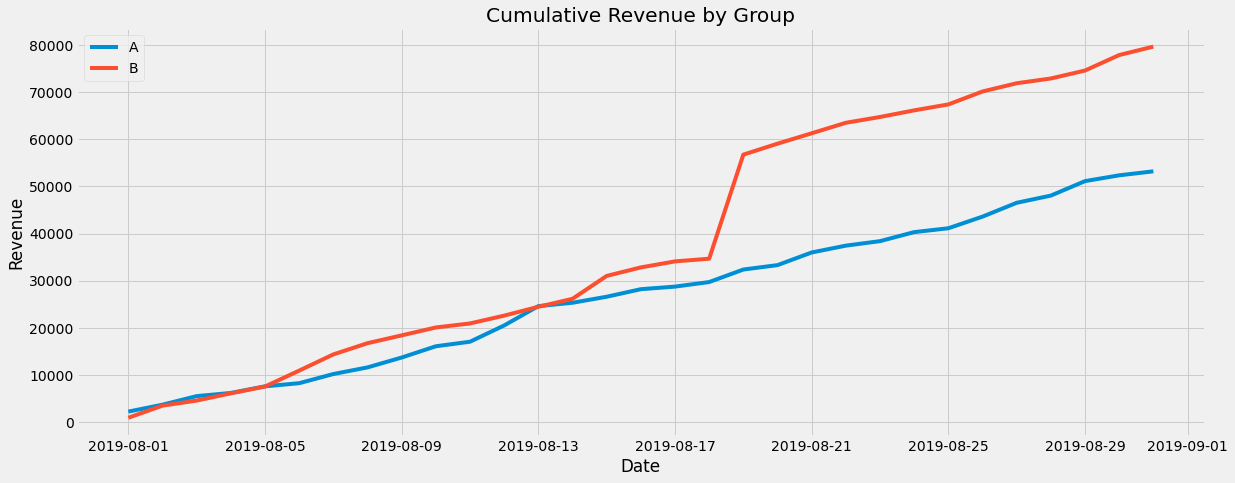

In [22]:
# set figure size for the graph 
plt.figure(figsize=(18, 7))

# dataframe with cumulative orders and cumulative revenue by day, group A
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# dataframe with cumulative orders and cumulative revenue by day, group B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# plotting the group A revenue graph 
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# plotting the group B revenue graph 
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

#set title and x/y labels
plt.title('Cumulative Revenue by Group')
plt.xlabel('Date')
plt.ylabel('Revenue')

plt.legend()
plt.show()

Key insights from the graph:
- Revenue is rising steadily throughout the whole test. That's a good sign.


- We can see that group B see spikes in revenue at certain point (from 2019-08-18 to 2019-08-19). This may imply either a surge in the number of orders or the presence of very expensive orders in the sample.


- Overall, throughout the whole period of the test, group B's cumulative revenue is higher or equal than group A's cumulative revenue.

### Graph cumulative average order size by group.

<a class="anchor" id="question2"></a>
[Go back to the Table of Contents](#table_of_contents)

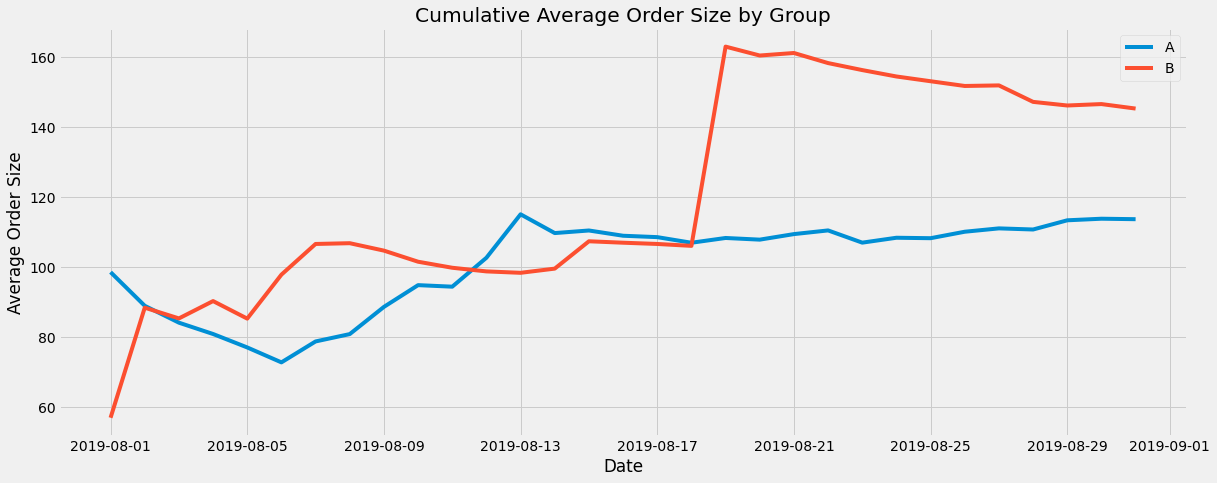

In [23]:
# set figure size for the graph 
plt.figure(figsize=(18, 7))

# plotting the group A average order size graph 
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'], label='A')

# plotting the group B average order size graph 
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], label='B')

#set title and x/y labels
plt.title('Cumulative Average Order Size by Group')
plt.xlabel('Date')
plt.ylabel('Average Order Size')

plt.legend()
plt.show()

Key insights from the graph:

- Average purchase size becomes somewhat steady by the end of the test, it stabilizes for group A (with a silght rise towards the end) and keeps on falling for group B after the surge we saw from 2019-08-18 to 2019-08-19.


- The surge in group B in the second half of the test may have been due to the presence of large, expensive orders.


- Overall, for the most part, group B's cumulative average order size is higher than group A's  cumulative average order size. 

### Graph the relative difference in cumulative average order size for group B compared with group A.

<a class="anchor" id="question3"></a>
[Go back to the Table of Contents](#table_of_contents)

Let's plot a relative difference graph for the cumulative average purchase sizes. We'll add a horizontal axis with the `axhline()` method.

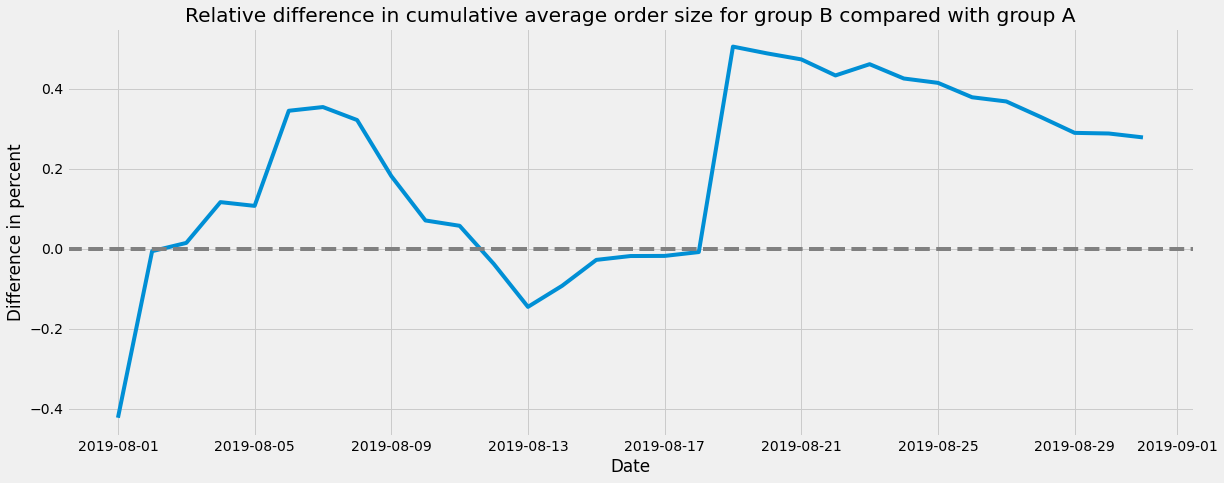

In [24]:
# set figure size for the graph 
plt.figure(figsize=(18, 7))

# gathering the data into one dataframe
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB,
                                                   left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# plotting a relative difference graph for the average purchase sizes
plt.plot(mergedCumulativeRevenue['date'],
         (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB']) / 
         (mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersA']) -1)

# adding the X axis
plt.axhline(y=0, color='gray', linestyle='--') 

#set title and x/y labels
plt.title('Relative difference in cumulative average order size for group B compared with group A')
plt.xlabel('Date')
plt.ylabel('Difference in percent')

plt.show()

Key insights from the graph:

- At several points the difference between the groups spikes. This means there must be some big/expensive orders and outliers.


- The behaviour of the previous graph apply here as well, for the most part group B's average order size is higher when compared to group A.


- The range of the relative difference is between -0.4 to 0.4.

### Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference.

<a class="anchor" id="question4"></a>
[Go back to the Table of Contents](#table_of_contents)

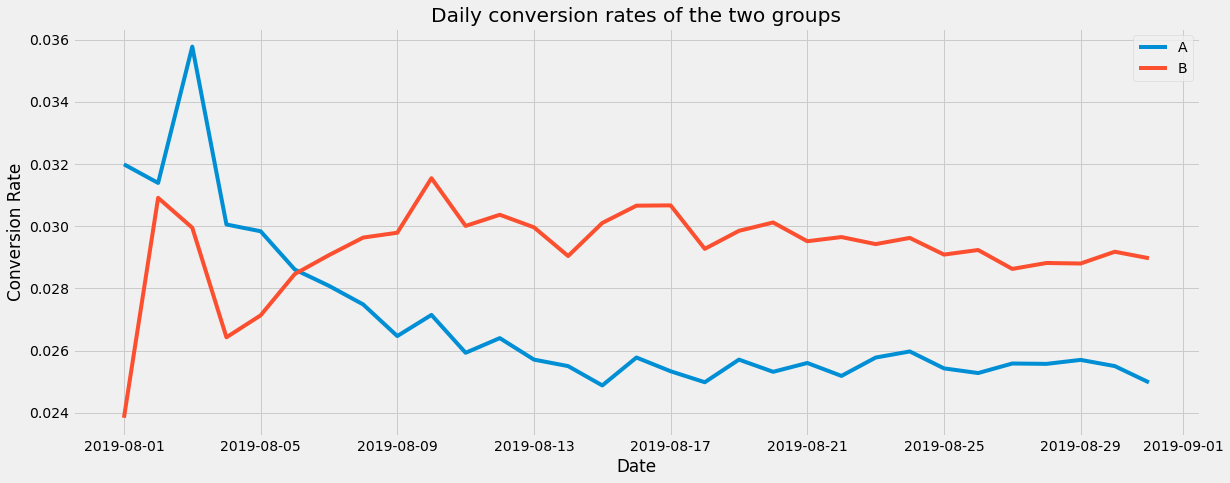

In [25]:
# set figure size for the graph 
plt.figure(figsize=(18, 7))

# calculating cumulative conversion
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

# selecting data on group A 
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# selecting data on group B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# plotting the graphs
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

#set title and x/y labels
plt.title('Daily conversion rates of the two groups')
plt.xlabel('Date')
plt.ylabel('Conversion Rate')

plt.legend()
plt.show()

Key insights from the graph:

- At the begining of the test, conversion rate of group A was higher than group B.


- Later on in the first half for the test, the conversion rate of group A dropped and then stabilized, while the conversion rate of group B rose, passed group A and then stabilized towards the end of the test.

Let's plot a relative difference graph for the cumulative conversion rates:

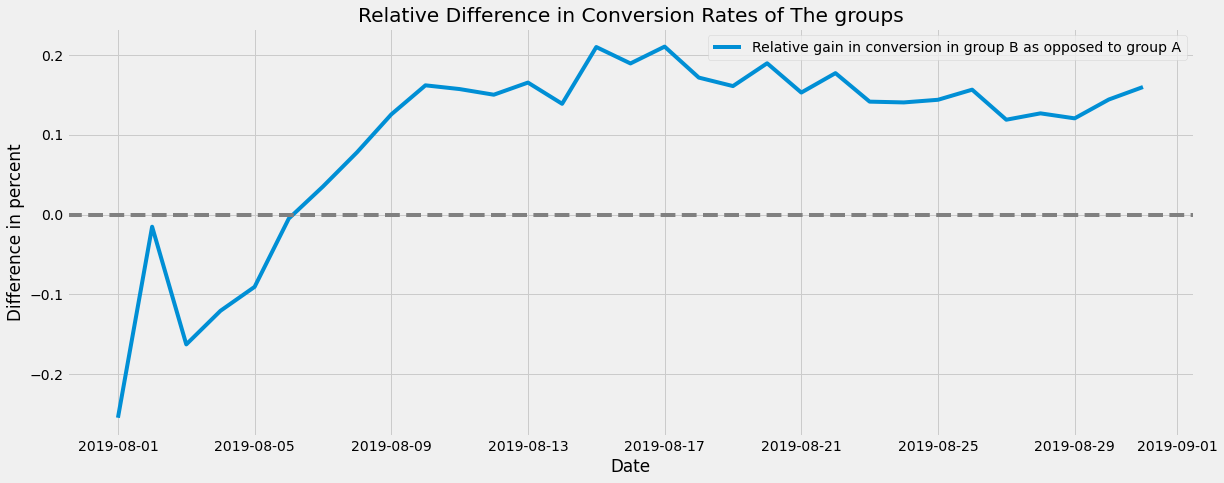

In [26]:
# set figure size for the graph 
plt.figure(figsize=(18, 7))

# merge the dataframes with data about conversion rate for each group
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

#plot a line chart to demonstrate the relative difference in conversion rate between the groups
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Relative gain in conversion in group B as opposed to group A")

# add horizontal line in value 0
plt.axhline(y=0, color='gray', linestyle='--')

#set title and x/y labels
plt.title('Relative Difference in Conversion Rates of The groups')
plt.xlabel('Date')
plt.ylabel('Difference in percent')

plt.legend()
plt.show()

Putting aside the first 6 days of the test, the relative gain in conversion in group B is higher as opposed to group A.

### Plot a scatter chart of the number of orders per user.

<a class="anchor" id="question5"></a>
[Go back to the Table of Contents](#table_of_contents)

Let's find the number of orders per user:

In [27]:
# aggregate the number of unique orders for each customer
ordersPerUsers = (
    orders.drop(['revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique,
         'group': 'max'})
)

#rename the columns
ordersPerUsers.columns = ['visitorId', 'orders', 'group']

Next, let's plot a scatter chart of the number of orders per user:

C:\Users\alon4\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


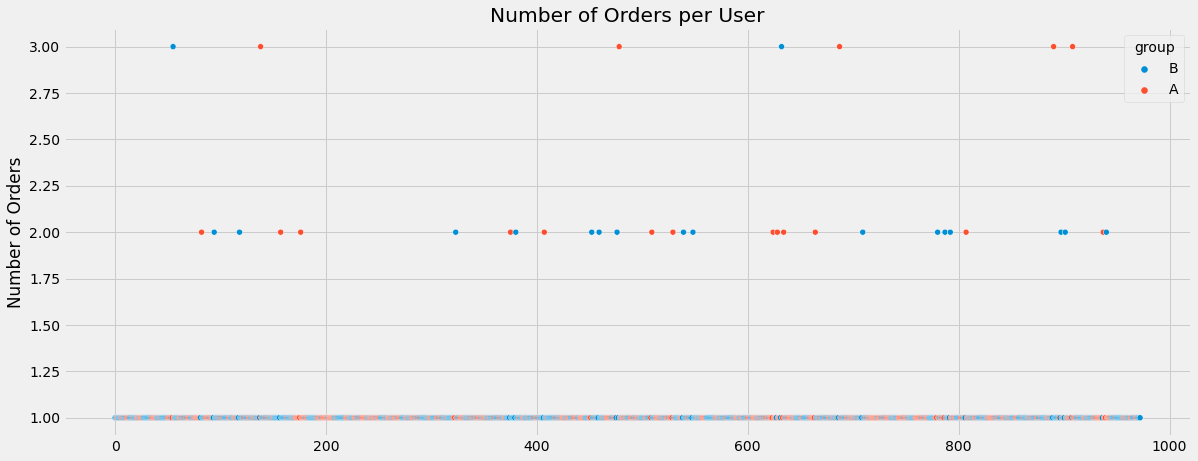

In [28]:
# set figure size for the graph 
plt.figure(figsize=(18, 7))

#set x axis range of values
x_range_of_order_per_user = pd.Series(range(0,len(ordersPerUsers)))

#plot a scatter chart
sns.scatterplot(x_range_of_order_per_user, ordersPerUsers['orders'], data=ordersPerUsers, hue='group')

#set title and x/y labels
plt.title('Number of Orders per User')
plt.ylabel('Number of Orders')

plt.show()

The vast majority of customers in `orders`, ordered only once during the test, a few ordered twice, and only 7 users ordered 3 times.

Users that ordered 3 times definitely canbe called outliers, about users with 2 orders, we'll need to further analyze if we want to determine if they are outliers too or not.

### Calculate the 95th and 99th percentiles for the number of orders per user.

<a class="anchor" id="question6"></a>
[Go back to the Table of Contents](#table_of_contents)

Let's calculate percentiles for the number of orders per user:

In [29]:
print('The 95th and 99th percentiles for the number of orders per user are: \n{}'
      .format(np.percentile(ordersPerUsers['orders'], [95, 99])))

The 95th and 99th percentiles for the number of orders per user are: 
[1. 2.]


Now it's clear, users with more than 2 orders account for 1% of the data about users who made orders, therefore they should be considered to be outliers.

### Plot a scatter chart of order prices.

<a class="anchor" id="question7"></a>
[Go back to the Table of Contents](#table_of_contents)

Let's use a scatter chart to evaluate order prices:

C:\Users\alon4\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


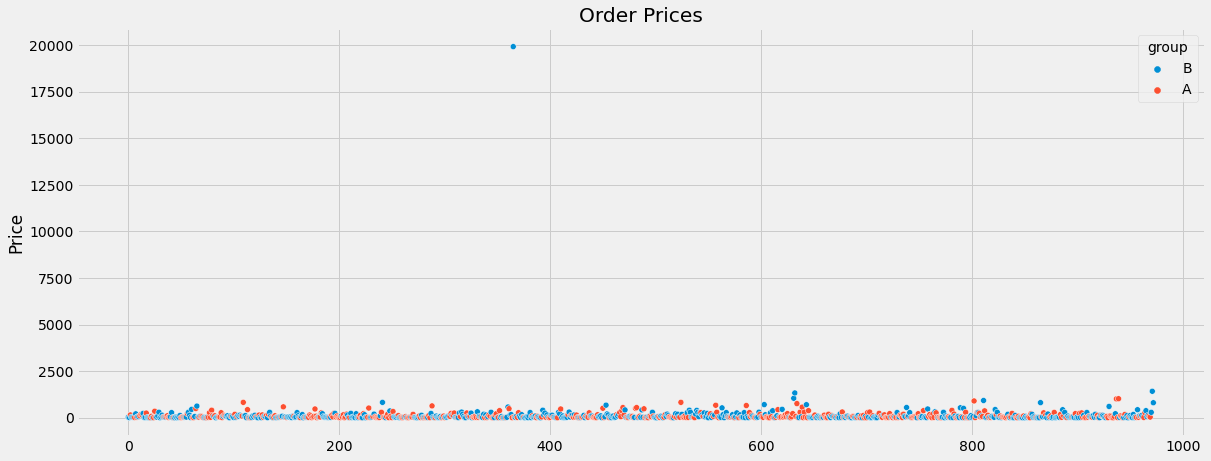

In [30]:
# set figure size for the graph 
plt.figure(figsize=(18, 7))

#set x axis range of values
x_range_of_order_price = pd.Series(range(0, len(orders['revenue'])))

#plot a scatter chart
sns.scatterplot(x_range_of_order_price, orders['revenue'], data=ordersPerUsers, hue='group')

#set title and x/y labels
plt.title('Order Prices')
plt.ylabel('Price')

plt.show()

<div class="alert alert-info"> 
<b>Student's comment</b> 
 Changed.
</div>

Just as we expected earlier when we compared metrics between the groups, there is one big order, which might have caused the spike we saw in group b average order size from 2019-08-18 to 2019-08-19.

Except for that, we got one order above 2,500 and that it, all the other orders are below 2,500.

### Calculate the 95th and 99th percentiles of order prices.

<a class="anchor" id="question8"></a>
[Go back to the Table of Contents](#table_of_contents)

Let's calculate percentiles of order prices:

In [31]:
print('The 95th and 99th percentiles of order prices are: \n{}'
      .format(np.percentile(orders['revenue'], [95, 99])))

The 95th and 99th percentiles of order prices are: 
[414.275 830.3  ]


We'll determine orders with price above 830 to be outliers, as you can see above, orders above 830 account for only 1% of the data.

### Find the statistical significance of the difference in conversion between the groups using the raw data. 

<a class="anchor" id="question9"></a>
[Go back to the Table of Contents](#table_of_contents)

First, let's formulate our hypothesis and set the significance criterion:

In this case our null hypothesis would be:

- Conversion rate of group A and group B are equals.

And the alternative hypothesis would be:

- Conversion rate of group A and group B are the not equals.

We chose to use alpha value of 5% since its considered to be the 'golden standard'.

Let's calculate the statistical significance of the difference in conversion between the groups.

We'll create the variables ordersPerUsersA and ordersPerUsersB to store the columns `['visitorId', 'orders']`. For users with at least one order, we'll indicate the number of orders made.

In [32]:
ordersPerUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersPerUsersA.columns = ['visitorId', 'orders']

ordersPerUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersPerUsersB.columns = ['visitorId', 'orders']

Now we'll declare the variables `sampleA` and `sampleB`, with users from different groups and corresponding numbers of orders. Those who didn't order anything will have 0. This is necessary to prepare the samples for the Mann-Whitney test.

The samples must have two parts:
- A list of the number of orders for each user.


- Zeroes for users who didn't order anything. Their number is the difference between the total number of visitors and the number of records on orders.

In [33]:
# we used the np.arange() function to create a list of indices. 
# it works like the range() function but creates an array of indices in the np.array format required by pd.Series

# concatenate series objects by row for sample A
sampleA = pd.concat([ordersPerUsersA['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersPerUsersA['orders'])), name='orders')],axis=0)

# concatenate series objects by row for sample B
sampleB = pd.concat([ordersPerUsersB['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersPerUsersB['orders'])), name='orders')],axis=0)

print("The p-value is: {0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print("The relative difference is: {0:.3f}".format(sampleB.mean() / sampleA.mean()-1)) 

The p-value is: 0.006
The relative difference is: 0.160


**Conclusions:**
- Based on the raw data, there is a difference between groups A and B in terms of conversion rate.


- The p-value is 0.006, which is below 0.05 (our significance criterion). Assuming our null hypothesis was that there is no significant difference between the groups (A and B) in terms of conversion rate, we can reject the null hypothesis which means there is a significant difference between the samples.


- The relative difference is 16%, which means that the conversion rate of group B is 16% better than the one of group A!

### Find the statistical significance of the difference in average order size between the groups using the raw data.

<a class="anchor" id="question10"></a>
[Go back to the Table of Contents](#table_of_contents)

In this case our null hypothesis would be:

- Average order size of group A and group B are the same.

And the alternative hypothesis would be:

- Average order size of group A and group B are the not the same.

We chose to use alpha value of 5% since its considered to be the 'golden standard'.

In [34]:
#perform Mann-Whitney test on average order size of group A compared to group B
print('The p-value is: {0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

# calculate the relative difference between group A and group B in terms of average order size
print('The relative difference is: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

The p-value is: 0.431
The relative difference is: 0.278


**Conclusions:**
- Based on the raw data, there isn't a difference between groups A and B in terms of average order size.


- The p-value is 0.431, which is greater than 0.05 (our significance criterion). Assuming our null hypothesis was that there is no significant difference between the groups (A and B) in terms of average order size. We can't reject the null hypothesis.


- The relative difference is 27.8%, which means that the average order size of group B is 27.8% bigger than the one of group A.

### Find the statistical significance of the difference in conversion between the groups using the filtered data. 

<a class="anchor" id="question11"></a>
[Go back to the Table of Contents](#table_of_contents)

In this case our null hypothesis would be:

- Conversion rate of group A and group B are equals.

And the alternative hypothesis would be:

- Conversion rate of group A and group B are the not equals.

We chose to use alpha value of 5% since its considered to be the 'golden standard'.

Earlier we determined that users would be considered abnormal users if:
1. They have 3 or more orders.
2. Their order exceed the price of 830.

Let's make data slices with the users who placed more than 2 orders (`usersWithManyOrders`) and the users who placed orders for more than 830 (`usersWithExpensiveOrders`). We'll join them in a table called `abnormalUsers`.

In [35]:
# set limit variable for limit we calculated eariler
order_lim = 2
revenue_lim = 830

# filter users with more than 2 orders for each group
usersWithManyOrders = pd.concat([ordersPerUsersA[ordersPerUsersA['orders'] > order_lim]['visitorId'], ordersPerUsersB[ordersPerUsersB['orders'] > order_lim]['visitorId']], axis = 0)

# filter users with order's price of more than 830
usersWithExpensiveOrders = orders[orders['revenue'] > revenue_lim]['visitorId']

# concatenate the tables above  
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
#print first 5 rows
print(abnormalUsers.head(5))
#print the number of abnormal users
print(abnormalUsers.shape)

937    148427295
33     249864742
58     611059232
811    887908475
632    888512513
Name: visitorId, dtype: int64
(19,)


In total, we have 19 abnormal users.

Next, we'll repeat the steps we took earlier for the raw data, only this time we'll be using the filtered data.

Let's create samples for both groups using the filtered data:

In [36]:
sampleAFiltered = pd.concat([ordersPerUsersA[np.logical_not(ordersPerUsersA['visitorId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersPerUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersPerUsersB[np.logical_not(ordersPerUsersB['visitorId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersPerUsersB['orders'])),name='orders')],axis=0)

Let's apply the statistical Mann-Whitney criterion to the resulting samples:

In [37]:
print("The p-value is: {0:.3f}".format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("The relative difference is: {0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

The p-value is: 0.003
The relative difference is: 0.192


**Conclusions:**
- Based on the filtered data, there is a difference between groups A and B in terms of conversion rate. The same conclusion from the raw data, apply here as well.


- The p-value is 0.003, which is below 0.05 (our significance criterion). Assuming our null hypothesis was that there is no significant difference between the groups (A and B) in terms of conversion rate, we can reject the null hypothesis which means there is a significant difference between the samples.


- The relative difference is 19.2%, 3.2% higher than the result we got from the raw data, which means that the conversion rate of group B is 19.2% better than the one of group A!

### Find the statistical significance of the difference in average order size between the groups using the filtered data.

<a class="anchor" id="question12"></a>
[Go back to the Table of Contents](#table_of_contents)

In this case our null hypothesis would be:

- Average order size of group A and group B are the same.

And the alternative hypothesis would be:

- Average order size of group A and group B are the not the same.

We chose to use alpha value of 5% since its considered to be the 'golden standard'.

Using `abnormalUsers` we'll filter the data, and repeat the same steps we took before to find the statistical significance of the difference in average order size between the groups.

In [38]:
print('{0:.3f}'.format(st.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print('{0:.3f}'.format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

0.438
-0.014


**Conclusions:**
- Based on the raw data, there isn't a difference between groups A and B in terms of average order size. The same conclusion from the raw data, apply here as well.


- The p-value is 0.438, which is greater than 0.05 (our significance criterion). Assuming our null hypothesis was that there is no significant difference between the groups (A and B) in terms of average order size. We can't reject the null hypothesis.


- The relative difference is -1.4%, 26.4% lower than the result we got from the raw data!. It's clear as day that outlier heavily affected the result of the raw data. From the result of the filtered data we can see the average order size of group B is 1.4% lower than the one of group A.

### Make a decision based on the test results.

<a class="anchor" id="decision"></a>
[Go back to the Table of Contents](#table_of_contents)

**Here are the facts:**

- Both raw, and filtered data revealed statistically significant differences in conversion between the groups.


- Neither raw nor filtered data revealed any statistically significant differences in average order size between the groups.


- The graph showing the difference in conversion between the groups tells us that group B's results are better significantly.


- The graph showing the difference in average order size between the groups tells us that group B's results are getting worse from day to day and are currently ~30% above group A's.

Based on these facts, we can conclude that the test is partly successful and should be stopped. There's no use continuing it, since the probability that segment B's average order size will turn out to be better than segment A's is very low.

On the other hand, we did find a statistical significance of the difference in conversion rate between the groups, for both raw/filtered data.